Exploring the kaggle dataset capturing student achievement in secondary education of two Portuguese schools.

We follow a comprehensive, but not exhaustive, analysis of the data. It is far from a rigorous study in this notebook, but the data analysis principles explored here should be sufficient for us to model.

In [260]:
#Import
import pandas as pd
import seaborn as sns
import pathlib 
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [178]:
#Loading data from csv file
inputpath = pathlib.Path.cwd() / 'input' / 'student-por.csv'
df_train = pd.read_csv(inputpath)


In [179]:
print(f"Number of rows/records: {df_train.shape[0]}")
print(f"Number of columns/variables: {df_train.shape[1]}")
print(list(df_train.columns))

df_train.info()

Number of rows/records: 649
Number of columns/variables: 33
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      649 non-null    object
 1   sex         649 non-null    object
 2   age         649 non-null    int64 
 3   address     649 non-null    object
 4   famsize     649 non-null    object
 5   Pstatus     649 non-null    object
 6   Medu        649 non-null    int64 
 7   Fedu        649 non-null    int64 
 8   Mjob        649 non-null    object
 9   Fjob        649 non-null    object
 10  reason      649 non-nu

<AxesSubplot:>

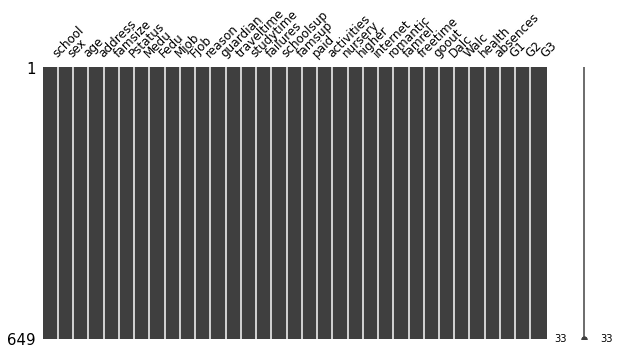

In [180]:
#Check for missing data
msno.matrix(df_train, figsize=(10, 5), fontsize=12)

1. Understanding the Problem

In order to understand our data, we can look at each variable and try to understand their meaning and relevance to this problem. This is time-consuming but will offer us the flavour of the our dataset.

To have some discipline in our analysis, we can create an Excel spreadsheet with the following columns:

1. Variable - Variable name.

2. Type - Identification of the variables' type. There are two possible values for this field: 'numerical' or 'categorical'. By 'numerical' we mean variables for which the values are numbers, and by 'categorical' we mean variables for which the values are categories.

3. Segment - Identification of the variables' segment. We can define three possible segments: physical, family, education, leisure. The segment 'physical' refers to variables that give information on the characteristics of the student (e.g. 'sex' and 'health'). The segment 'family' refer to the variables that give information on the familial environment of student (e.g. 'Mjob' and 'Pstatus'). The segment 'education' refers to variables that give information on the educational history and habits of the students (e.g. 'studytime' and 'absences'). The segment 'leisure' refers to variables that give information on the non-educational history and habits of the student (e.g. 'freetime' and 'goout').

4. Expectation - Our expectation about the variable influence in 'G3'. We can use a categorical scale with 'High', 'Medium' and 'Low' as possible values.

5. Conclusion - Our conclusions about the importance of the variable, after we give a quick look at the data. We can keep with the same categorical scale as in 'Expectation'.

6. Comments - Any general comments that occured to us.

While "Type" & "Segment" are used for future possible reference, "Expectation" is important in developing an intuition for the dataset. We filter the spreadsheet and then perform some preliminary scatter and bar plots before filling in the conclusion, which is the correction of our expectations.
 
Going through the process, we expect that the following variables play an important role in 'G3':

1. studytime
2. failures
3. schoolsup
4. famsup
5. paid
6. absences
7. G1
8. G2

We expect mostly variable relating to previous scores ('G1', 'G2', 'failures'), attendance ('absences'), educational support ('schoolsup', 'famsup', 'paid') and individual studying habits ('studytime').

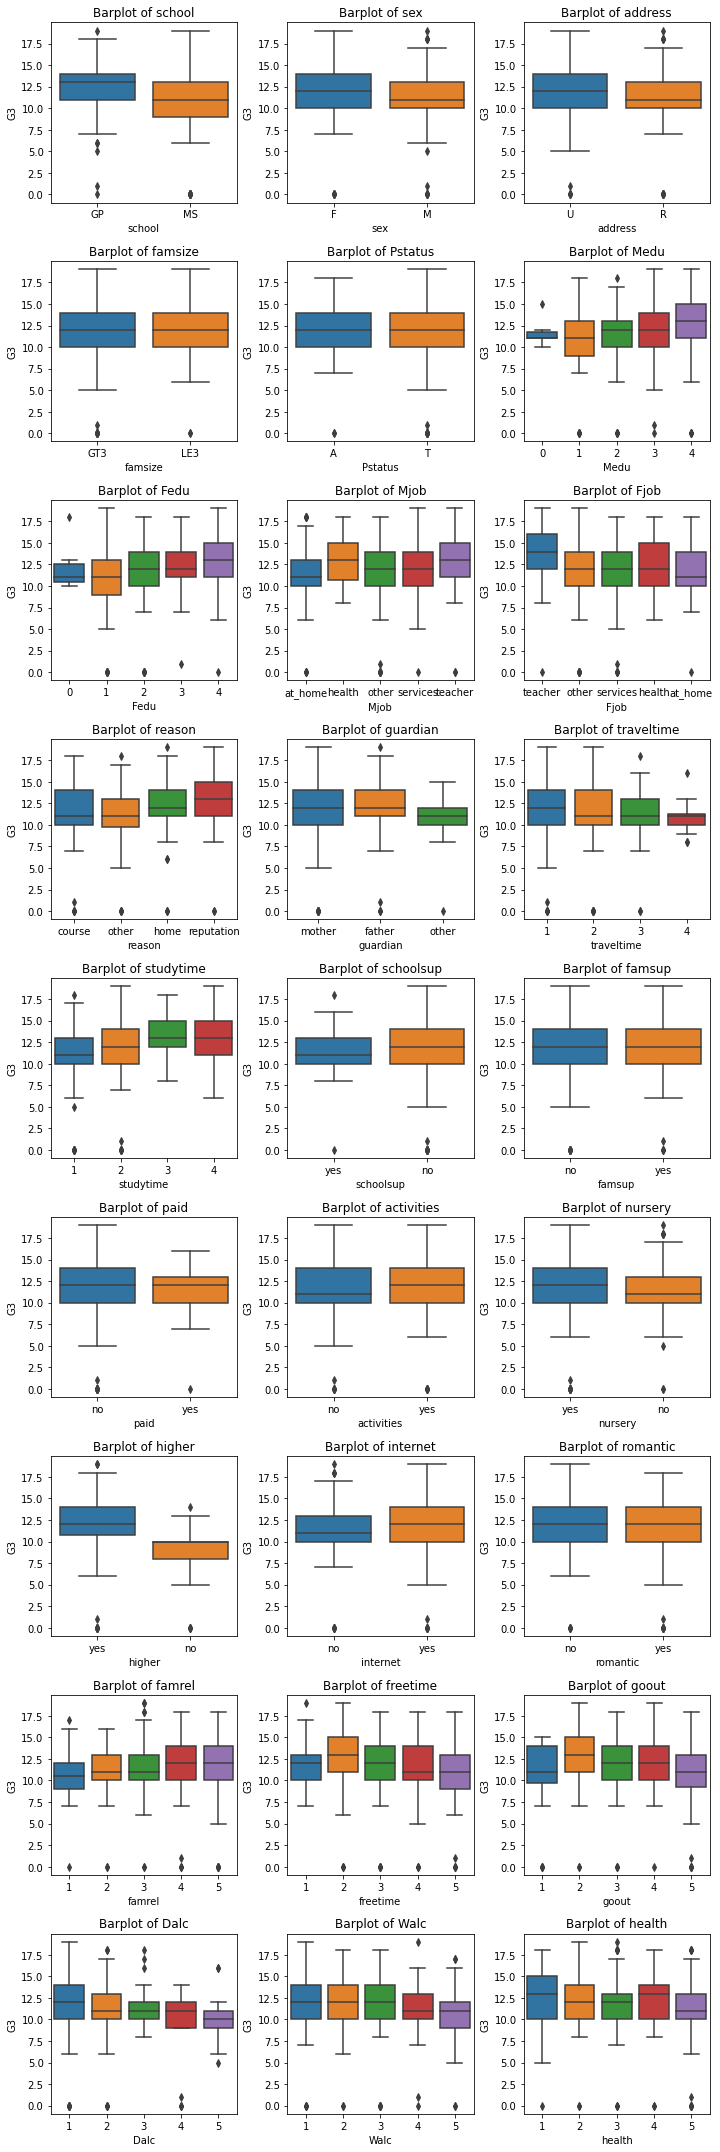

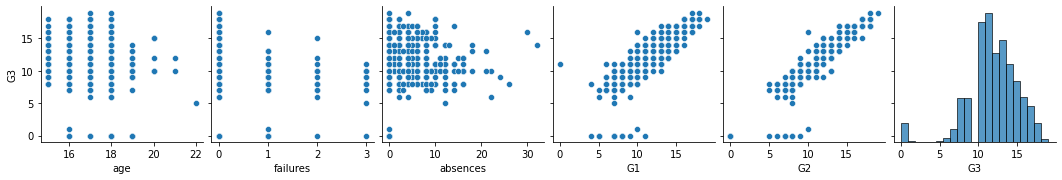

In [181]:
df_train_bar = df_train[[
    'school', 'sex', 'address', 'famsize', 'Pstatus',
    'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason',
    'guardian', 'traveltime', 'studytime', 'schoolsup', 'famsup',
    'paid', 'activities', 'nursery', 'higher', 'internet',
    'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
    'Walc', 'health'
]]

df_train_scatter = df_train[[
    'age', 'failures', 'absences', 'G1', 'G2', 'G3',
]]

plt.figure(figsize=(10, 30))

for i, col in enumerate(df_train_bar):
    plt.subplot(9,3,1+i)
    sns.boxplot(data=df_train_bar, x=col, y=df_train_scatter['G3'])
    plt.title((f'Barplot of {col}'))

plt.tight_layout()
plt.show()

sns.pairplot(data=df_train_scatter, y_vars=['G3'])

Upon some quick, preliminary data examination, we have a refined set of conclusions for important variables:

1. address
2. traveltime
3. studytime
4. higher
5. dalc
6. absence
7. failure
8. g1
9. g2

We include "Dalc", which was not expected to be as relevant, but on hindsight after data examination could indirectly capture usage of leisure time. 
We include 'traveltime', this could be highly correlated to other factors such as address, but could also mean that more time spent travelling indicates less time available for study, leisure.
We include "address", this is interesting as there could significant cultural, location and family structures for urban and rural communities.
we include "higher", which seems to unexpectedly play a significant in "G3', this makes sense as students who wish to enter college often are required to have a good academic score to qualify.

We remove "schoolsup", "famsup" and "paid", counterintuitively, it seems that education support does not necessarily have as significant an impact on 'G3".

Important note from the paper source: the target attribute G3 has a strong correlation with attributes G2 and G1. This occurs because G3 is the final year grade (issued at the 3rd period), while G1 and G2 correspond to the 1st and 2nd period grades.

In [182]:
df_train.describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
count,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000
mean,16.744222,2.514638,2.306626,1.568567,1.930663,0.221880,3.930663,3.180277,3.184900,1.502311,2.280431,3.536210,3.659476,11.399076,11.570108,11.906009
std,1.218138,1.134552,1.099931,0.748660,0.829510,0.593235,0.955717,1.051093,1.175766,0.924834,1.284380,1.446259,4.640759,2.745265,2.913639,3.230656
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,16.000000,2.000000,1.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,2.000000,0.000000,10.000000,10.000000,10.000000
50%,17.000000,2.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,2.000000,11.000000,11.000000,12.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,6.000000,13.000000,13.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,32.000000,19.000000,19.000000,19.000000


In [183]:
num_var = ['age', 'failures', 'absences', 'G1', 'G2', 'G3']
num_ordinal_var = ['traveltime', 'studytime', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'Medu', 'Fedu']

non_num_cat_var = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']


<AxesSubplot:xlabel='G3', ylabel='Density'>

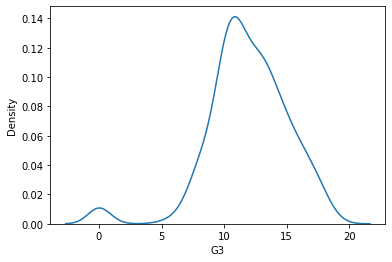

In [184]:
sns.kdeplot(df_train['G3'])

- Deviates from a normal distribution
- Appreciable negative skewness
- Approxmiately Mesokurtic peakedness
- Clear trough between two peak maxima

We can see two different populations, albeit small, within the class, one group of higher achievers, with a high mean score, and a second group of relative underperformers, with a lower mean score.

In [185]:
print("Skewness: %f" % df_train['G3'].skew())
print("Kurtosis: %f" % df_train['G3'].kurt())

Skewness: -0.912909
Kurtosis: 2.712204


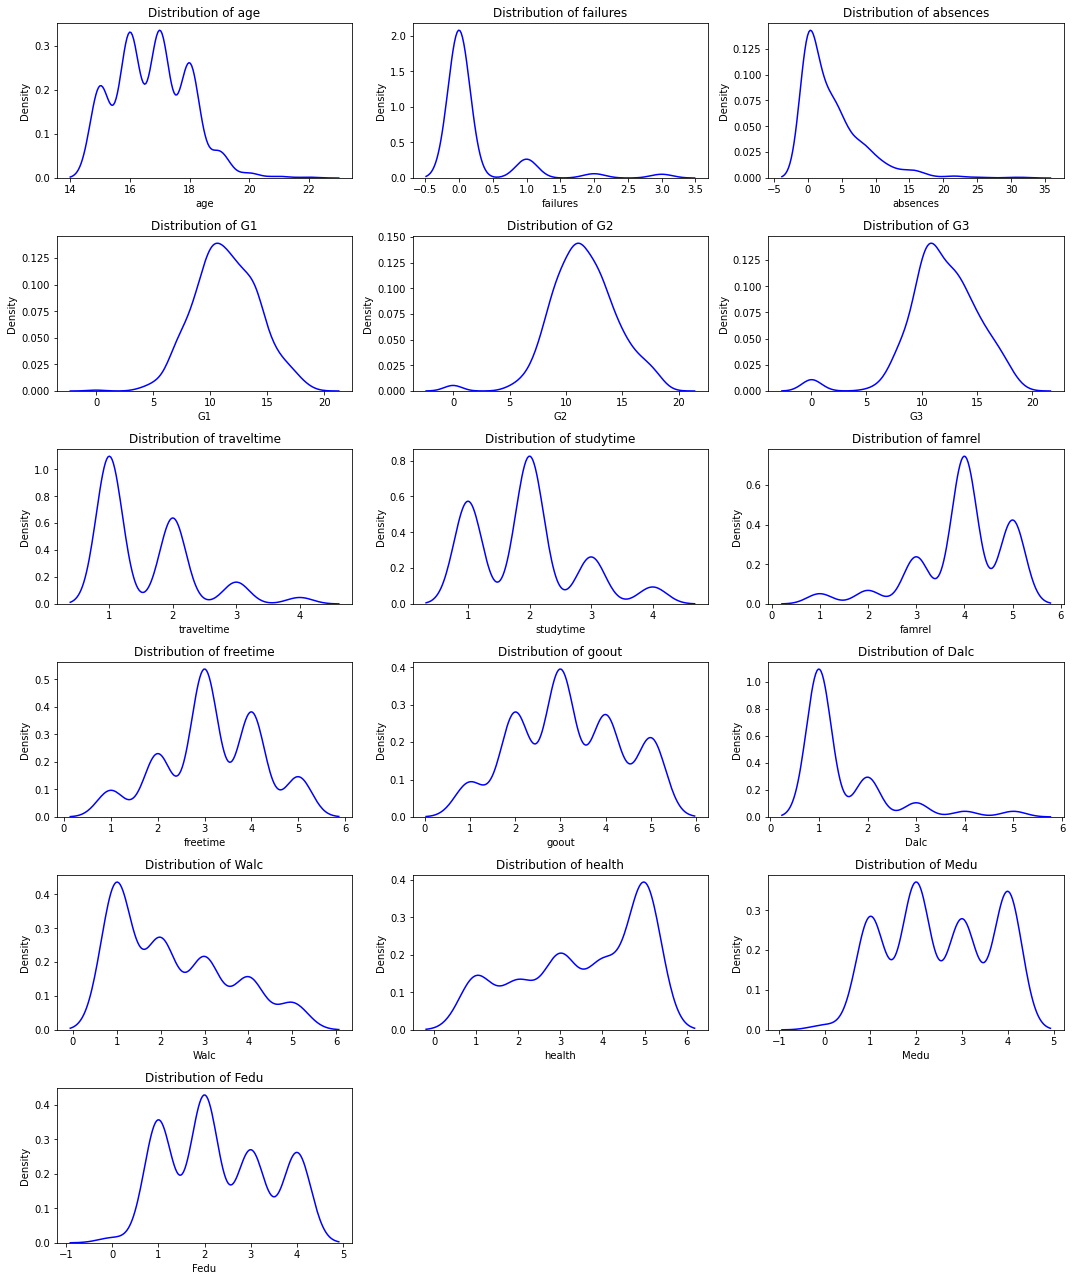

In [186]:
# Check distribution
plt.figure(figsize=(15, 50))
for i, col in enumerate(num_var + num_ordinal_var):
    # Plot distribution 
    plt.subplot(17,3,i+1)
    sns.kdeplot(df_train[col], color='blue')
    plt.title(f'Distribution of {col}')
# Show the plot
plt.tight_layout()
plt.show()

<AxesSubplot:>

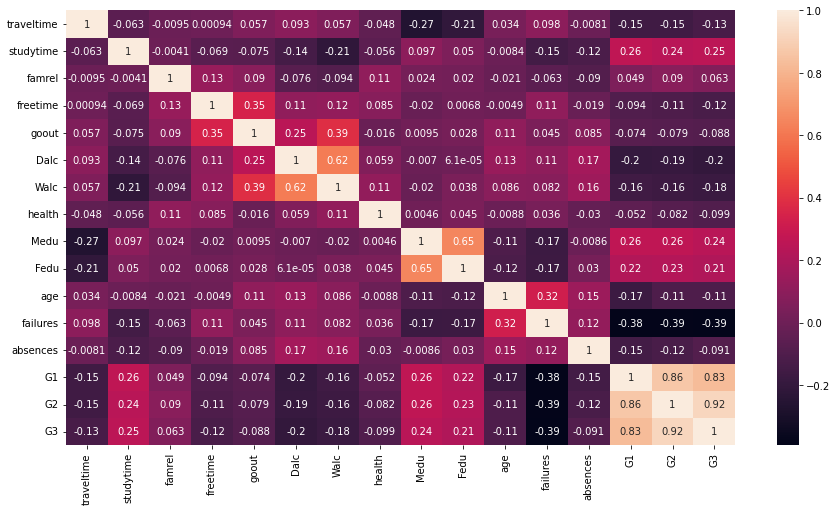

In [187]:
plt.figure(figsize=(15,8))
sns.heatmap(df_train[num_ordinal_var + num_var].corr(),annot=True)

<AxesSubplot:>

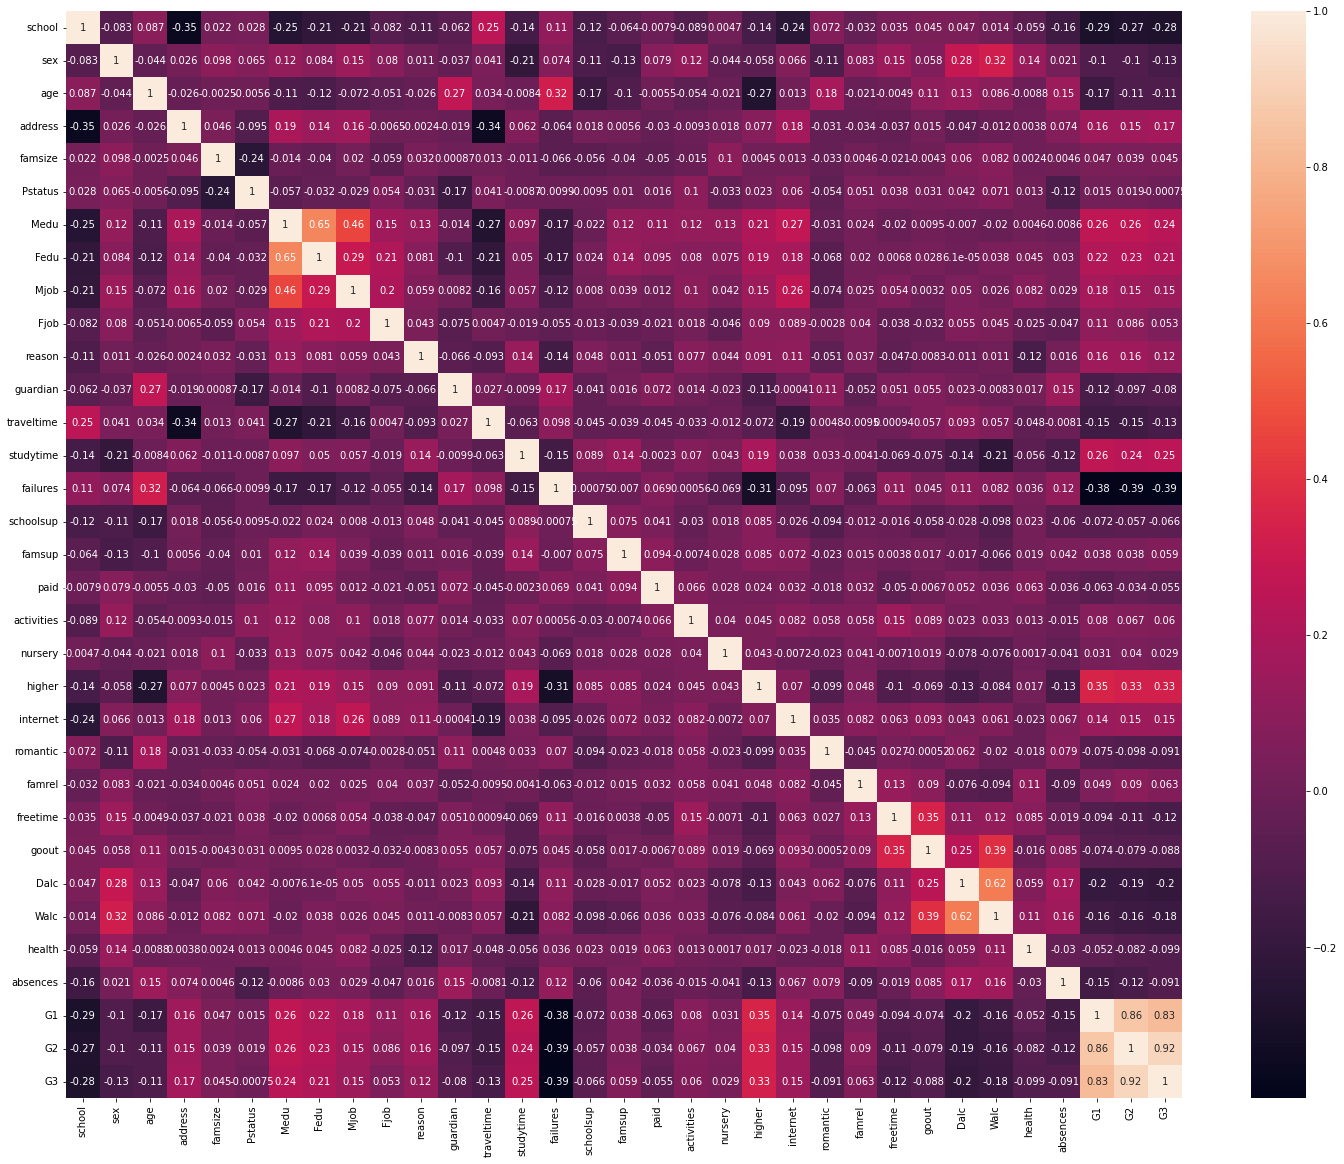

In [188]:
encoded_df = df_train.iloc[:].copy()
columns = encoded_df[non_num_cat_var].columns
hotone_encode = OrdinalEncoder()
encoded_df[columns] = hotone_encode.fit_transform(encoded_df[columns])

plt.figure(figsize=(25,20))
sns.heatmap(encoded_df.corr(), annot=True)

We can get additional information from our categorical variables. Most correlation G3 has with interest in higher education, school, sex, address, internet access and mother's job. Prepare a total pipeline to encode nominal varables and binary variables separately with OneHotEncoder and OrdinalEncoder. Otherwise we introduce some order to nominal categories, which can lead to mistakes of our model.

In [189]:
#Train Test Split
train, test = train_test_split(df_train, test_size=0.2, random_state=0)

X_train = train.drop(['G3'], axis=1)
Y_train = train[['G3']].copy()

X_test = test.drop(['G3'], axis=1)
Y_test = test[['G3']].copy()

In [190]:
binary = ['school',
 'sex',
 'address',
 'famsize',
 'Pstatus',
 'schoolsup',
 'famsup',
 'paid',
 'activities',
 'nursery',
 'higher',
 'internet',
 'romantic']

nominal = ['Mjob', 'Fjob', 'reason', 'guardian']

to_scale = ['age', 'absences', 'G2', 'G1']

In [191]:
full_pipeline = ColumnTransformer([("bin", OrdinalEncoder(), binary),
                                   ("cat", OneHotEncoder(), nominal),
                                  ("num", StandardScaler(), to_scale)], remainder='passthrough')

train_encoded = full_pipeline.fit_transform(X_train)
test_encoded = full_pipeline.fit_transform(X_test)


In [192]:
train_enc = pd.DataFrame(train_encoded)
train_enc.describe()

,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
count,519.000000,519.000000,519.000000,519.000000,519.000000,519.000000,519.000000,519.000000,519.000000,519.000000,...,519.000000,519.000000,519.000000,519.000000,519.000000,519.000000,519.000000,519.000000,519.000000,519.000000
mean,0.350674,0.423892,0.697495,0.304432,0.886320,0.105973,0.628131,0.055877,0.479769,0.799615,...,2.306358,1.562620,1.924855,0.240848,3.922929,3.188825,3.215800,1.518304,2.294798,3.556840
std,0.477642,0.494650,0.459786,0.460610,0.317729,0.308100,0.483770,0.229905,0.500073,0.400675,...,1.103075,0.758115,0.840653,0.613387,0.971522,1.042990,1.178827,0.956159,1.286923,1.447987
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,1.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,2.000000
50%,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,...,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,...,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [193]:
X = train_encoded
m = X.shape[0]

X_b = np.c_[np.ones((m, 1)), X]
X_b

array([[1., 0., 1., ..., 1., 1., 5.],
       [1., 1., 0., ..., 2., 2., 5.],
       [1., 0., 0., ..., 2., 3., 1.],
       ...,
       [1., 0., 1., ..., 3., 4., 3.],
       [1., 1., 0., ..., 1., 3., 1.],
       [1., 1., 1., ..., 1., 1., 4.]])

In [194]:
y = Y_train
#best_theta = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
best_theta = np.linalg.pinv(X_b).dot(y)  #used pseudoinverse instead of inverse
best_theta

array([[ 6.37676322e+00],
       [-1.86493383e-01],
       [-1.62240260e-01],
       [ 1.33708067e-01],
       [ 4.37398266e-02],
       [-1.42707025e-01],
       [-1.64335137e-01],
       [ 9.98755435e-02],
       [-3.21606110e-01],
       [ 1.14816519e-01],
       [-1.58134636e-01],
       [ 1.04260539e-01],
       [-2.83550863e-03],
       [-8.21670743e-02],
       [ 1.17026398e+00],
       [ 1.43132390e+00],
       [ 1.03195461e+00],
       [ 1.37991985e+00],
       [ 1.36330088e+00],
       [ 1.57371576e+00],
       [ 1.19273403e+00],
       [ 1.32669473e+00],
       [ 1.14819439e+00],
       [ 1.13542431e+00],
       [ 1.75129749e+00],
       [ 1.69798002e+00],
       [ 1.36502646e+00],
       [ 1.56245925e+00],
       [ 2.04387653e+00],
       [ 2.05852053e+00],
       [ 2.27436617e+00],
       [ 1.12298306e-02],
       [ 7.24881889e-02],
       [ 2.66238392e+00],
       [ 3.51990030e-01],
       [-1.13489595e-01],
       [ 2.81690433e-02],
       [ 1.44439080e-01],
       [ 4.7

In [295]:
test_encoded = full_pipeline.transform(X_test)
test_encoded

m = test_encoded.shape[0]

In [296]:
X_bT = np.c_[np.ones((m, 1)), test_encoded]
X_bT

array([[1., 1., 1., ..., 1., 4., 5.],
       [1., 0., 0., ..., 2., 3., 2.],
       [1., 0., 1., ..., 3., 4., 1.],
       ...,
       [1., 1., 0., ..., 1., 3., 4.],
       [1., 1., 1., ..., 3., 5., 5.],
       [1., 0., 1., ..., 4., 5., 3.]])

In [297]:
y_predict = X_bT.dot(best_theta)
y_predict

array([[ 6.60356112],
       [15.23755924],
       [16.59925703],
       [ 9.91144992],
       [ 8.48652408],
       [12.22327054],
       [12.94669105],
       [18.79095526],
       [11.33490488],
       [10.97946681],
       [10.57332663],
       [ 9.88086289],
       [13.34238653],
       [ 7.45091552],
       [18.73057797],
       [12.08526828],
       [12.7323578 ],
       [12.23913175],
       [10.4504771 ],
       [ 9.61370111],
       [11.91520834],
       [ 9.63678886],
       [17.43915004],
       [13.04741735],
       [12.44134865],
       [-0.50390359],
       [12.46993207],
       [13.3298658 ],
       [10.66512102],
       [12.57180928],
       [13.95974485],
       [16.61630479],
       [13.00472804],
       [16.08715353],
       [12.61056339],
       [ 8.63905312],
       [ 8.49809891],
       [11.10502872],
       [12.9389775 ],
       [11.0247233 ],
       [15.55633464],
       [18.01083149],
       [11.08434989],
       [13.30298967],
       [12.15233932],
       [ 8

In [298]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(Y_test, y_predict)
rmse = np.sqrt(mse)
rmse

r2_score(Y_test, y_predict)

0.8227086922108916

In [199]:
from sklearn.linear_model import LinearRegression

lin = LinearRegression()
lin.fit(train_encoded, Y_train)

LinearRegression()

In [200]:
lin.intercept_, lin.coef_

(array([-7.63809811e+11]),
 array([[-1.84001079e-01, -1.61590760e-01,  1.33909085e-01,
          4.44182340e-02, -1.42744479e-01, -1.64577548e-01,
          1.00339210e-01, -3.20875517e-01,  1.14714993e-01,
         -1.58103751e-01,  1.03910002e-01, -2.94552253e-03,
         -8.16876718e-02,  1.85578638e+11,  1.85578638e+11,
          1.85578638e+11,  1.85578638e+11,  1.85578638e+11,
         -1.08482783e+12, -1.08482783e+12, -1.08482783e+12,
         -1.08482783e+12, -1.08482783e+12,  1.11100066e+12,
          1.11100066e+12,  1.11100066e+12,  1.11100066e+12,
          5.52058342e+11,  5.52058342e+11,  5.52058342e+11,
          1.12851976e-02,  7.24089618e-02,  2.66253887e+00,
          3.51785323e-01, -1.13474730e-01,  2.81493314e-02,
          1.44432777e-01,  4.72821107e-02, -2.86437510e-01,
         -4.07759584e-02, -4.41677231e-02, -1.31754121e-02,
         -1.75050703e-02, -4.27035250e-02, -4.33312290e-02]]))

In [201]:
predictions = lin.predict(test_encoded)

In [294]:
mse_lin = mean_squared_error(Y_test, predictions)
rmse_lin = np.sqrt(mse_lin)
rmse_lin

r2_score(Y_test, predictions)

0.8227546651514837

In [203]:
alpha = 0.01 # learning rate
n_iterations = 20000
n = X_b.shape[1]

In [207]:
y = y.to_numpy().reshape(519,1)

def gradient_descent(alpha, x, y, numIterations):
    m = x.shape[0] # number of samples
    theta = np.random.randn(n,1)
    x_transpose = x.transpose()
    for iter in range(0, numIterations):
        hypothesis = np.dot(x, theta)
        loss = hypothesis - y
        
        gradient = np.dot(x_transpose, loss) / m         
        theta = theta - alpha * gradient  # update
    return theta

AttributeError: 'numpy.ndarray' object has no attribute 'to_numpy'

In [205]:
theta = gradient_descent(alpha, X_b, y, n_iterations)
theta

array([[ 5.91087866],
       [-0.16922672],
       [-0.16347637],
       [ 0.15911301],
       [ 0.0511094 ],
       [-0.10624231],
       [-0.14906822],
       [ 0.10354697],
       [-0.33707469],
       [ 0.11154802],
       [-0.14402897],
       [ 0.13774976],
       [ 0.01023379],
       [-0.07234962],
       [ 1.04868673],
       [ 1.27866934],
       [ 0.90345396],
       [ 1.23498309],
       [ 1.19511762],
       [ 2.11741461],
       [ 1.67976242],
       [ 1.86572769],
       [ 1.68881016],
       [ 1.66419928],
       [ 1.30181481],
       [ 1.24717166],
       [ 0.91133105],
       [ 1.11851704],
       [ 2.25368827],
       [ 2.27745537],
       [ 2.47183791],
       [ 0.01184738],
       [ 0.07535579],
       [ 2.65896397],
       [ 0.35369602],
       [-0.10247153],
       [ 0.0342774 ],
       [ 0.15922653],
       [ 0.05602218],
       [-0.27662181],
       [-0.02965066],
       [-0.03807696],
       [-0.01196752],
       [-0.01436468],
       [-0.0394631 ],
       [-0

In [303]:
y_predict = X_bT.dot(theta)

mse_gd = mean_squared_error(Y_test, y_predict)
rmse_gd = np.sqrt(mse_gd)
rmse_gd

r2_score(Y_test, y_predict)

0.8239340135515609

In [281]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(loss='squared_error', penalty="l1") # specifying Ridge Regression

sgd_reg.fit(train_encoded, Y_train)

C:\Users\sabri\miniconda3\envs\studentperformance\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SGDRegressor(penalty='l1')

In [302]:
accuracy=sgd_reg.score(test_encoded,Y_test) 
print(accuracy)
mean_squared_error(Y_test, sgd_reg.predict(test_encoded))




0.7798041378773564


1.5642505575737347

In [282]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

sp_data_model = DecisionTreeRegressor(random_state=1)

sp_data_model.fit(train_encoded, Y_train)

DecisionTreeRegressor(random_state=1)

In [283]:
val_predict = sp_data_model.predict(test_encoded)

In [286]:
val_mae = mean_absolute_error(val_predict, Y_test)
print("Val MAE for DecisionTreeRegressor: " )
print(val_mae)

r2_score(Y_test, val_predict)

Val MAE for DecisionTreeRegressor: 
0.9538461538461539


0.6448324115412808

In [291]:
rf_sp_data_model = RandomForestRegressor(random_state = 1)

#fit
rf_sp_data_model.fit(train_encoded, Y_train)

#predict
pred = rf_sp_data_model.predict(test_encoded)

#calculate MAE
rf_val_mae = mean_absolute_error(Y_test, pred)

print("Validation MAE for RandomForestRegressor: ")
print(rf_val_mae)

r2_score(Y_test, pred)

C:\Users\sabri\AppData\Local\Temp/ipykernel_5012/3197410502.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_sp_data_model.fit(train_encoded, Y_train)


Validation MAE for RandomForestRegressor: 
0.8144615384615385


0.8094974178716599

In [301]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from numpy import absolute
from numpy import mean
from numpy import std

model = Ridge(alpha=12)

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

scores = cross_val_score(model, train_encoded, Y_train, scoring='neg_mean_absolute_error',cv=cv, n_jobs=-1)

scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean MAE: 0.854 (0.144)
